<a href="https://colab.research.google.com/github/gabriel-inf/machine-learning-class-ufrgs/blob/master/k_fold_cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [248]:
import pandas as pd
import numpy as np
import random
from collections import Counter
from scipy.spatial import distance
!pip3 install plotly --upgrade

Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.10.0)


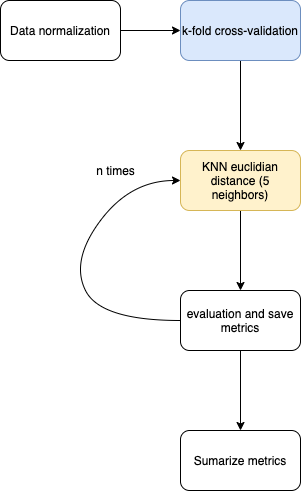

In [249]:
#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive/My Drive/UFRGS/'Ciência da Computação'/'7ª temporada'/'Aprendizado de máquina'/'TrabalhoCV_EnunciadoEDataset (1)'
#%ls -lth

# Preprocess

Importing the data and separating paramaters from label

In [250]:
# Read dataset
dataset = pd.read_csv("diabetes.csv")

# Filter out target class from normalization
outcomes = np.array(dataset['Outcome'])
dataset = dataset.drop(['Outcome'], axis=1)

# Normalize the values
dataset = (dataset-dataset.min())/(dataset.max()-dataset.min())
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000


Used for the post processes

In [251]:
accuracies = []
f_measures = []
truePos_trueNeg_falsePos_falseNeg = []

## Some definitions

### Similarity between two instances

For for the similarity between two instances I'm calculating the euclidian distance with the help of a linear algebra library

In [252]:
def calculate_distance(a: int, b: int) -> float:
  v1 = dataset.iloc[a].array
  v2 = dataset.iloc[b].array
  return np.linalg.norm(v1-v2)

Helper functions used to get the most frequent label and to transform a list of list into a flat list.

In [253]:
def get_most_frequent_label(neighbor_labels):
  return np.bincount(neighbor_labels).argmax()

def get_flat_list(list):
  flat_list = []
  for sublist in list:
      for item in sublist:
          flat_list.append(item)
  return flat_list

# KNN Algorithm Implementation

This functions executes the KNN algorithm:

**Given**
*   k: for the 'K'nn
*   labels: list of real labels
*   train_instances: array of integers that have the indexes of the train instances
*   instance_to_predict: int for the index of the instance under evaluation

**Returns**
*   int that represents the prediction [0,1]

In [254]:
def knn_implementation(k: int, labels: list,  train_instances: list, instance_to_predict: int):
  dinstances_to_instance = []
  for train_instance in train_instances:
    dinstances_to_instance.append(tuple([train_instance, calculate_distance(train_instance, instance_to_predict)]))
  
  dinstances_to_instance = sorted(dinstances_to_instance, key=lambda x: x[1], reverse=False)
  k_nearest_neighbors = [x[0] for x in dinstances_to_instance[:k]]
  k_nearest_neighbors_classes = []

  

  for neighbor in k_nearest_neighbors:
    k_nearest_neighbors_classes.append(labels[neighbor])


  return get_most_frequent_label(k_nearest_neighbors_classes)

# Folds generation

Randomly creates the folds by selecting one element from each class per iteration.

In [255]:
"""
  Returns k lists of lists that represent the folds
"""
def get_folds(k: int):
  dataset_size = dataset.shape[0]

  folds = []
  for i in range(0, k):
    folds.append([])

  possible_elements = [x for x in range(0, dataset_size)]
  possible_true = []
  possible_false = []

  for element in possible_elements:
    if outcomes[element] == 1:
      possible_true.append(element)
    else:
      possible_false.append(element)

  while len(possible_true + possible_false) > 0:
    for i in range(k):
      if len(possible_true) > 0:
        element = random.choice(possible_true)
        possible_true.remove(element)
        folds[i].append(element)
      if len(possible_false) > 0:
        element = random.choice(possible_false)
        possible_false.remove(element)
        folds[i].append(element)

  return folds

# Functions used to calculate the metrics

In [256]:
def get_prediction_metrics_parameters(predictions, test):
  true_positives = 0
  true_negatives = 0
  false_negatives = 0
  false_positives = 0

  for i in range(0, len(predictions)):

    if predictions[i] == outcomes[test[i]]:
      if predictions[i] == 1:
        true_positives += 1
      else:
        true_negatives += 1
    elif predictions[i] == 0:
      false_negatives += 1
    else:
      false_positives += 1

  return true_positives, true_negatives, false_positives, false_negatives


def calculate_acuracia(predictions, true_positives, true_negatives):
  return (true_positives + true_negatives) / len(predictions)

def calculate_recall(true_positives, false_negatives):
  return true_positives / (true_positives + false_negatives)

def calculate_precision(true_positives, false_positives):
  return true_positives / (true_positives + false_positives)

def calculate_fmeasure(test, beta, true_positives, false_positives, false_negatives):

  precision = calculate_precision(true_positives, false_positives)
  recall = calculate_recall(true_positives, false_negatives)

  return (1 + pow(beta,2)) * ((precision * recall) / ((pow(beta, 2) * precision) + recall))

# Function used to run the algorithm and collect the metrics

This is run k times in the k_fold_cross_validation

In [257]:
def evalutate_segmentation(train_instances, test_instances):
  predictions = []

  for instance in test_instances:
    predictions.append(knn_implementation(5, outcomes, train_instances, instance))

  true_positives, true_negatives, false_positives, false_negatives = get_prediction_metrics_parameters(predictions, test_instances)
  truePos_trueNeg_falsePos_falseNeg.append([true_positives, true_negatives, false_positives, false_negatives])
  accuracy = calculate_acuracia(predictions, true_positives, true_negatives)
  f_measure = calculate_fmeasure(test_instances, 1, true_positives, false_positives, false_negatives)
  return accuracy, f_measure

# Wrapping everything and returning the list of measures

In [258]:
def k_fold_cross_validation(k: int):
  folds = get_folds(k)

  accuracy = []
  f_measure = []
  # the i fold will be the test fold
  for i in range(0, k):
    test_instances = folds[i]
    train_instances = []
    for fold in [x for index,x in enumerate(folds) if index!=i]:
      for element in fold:
        train_instances.append(element)
    
    a, f = evalutate_segmentation(train_instances, test_instances)
    accuracy.append(a)
    f_measure.append(f)
  return accuracy, f_measure

In [259]:
accuracies, f_measures = k_fold_cross_validation(10)

# Data Analysis


In [260]:
import plotly.express as px

truePos_trueNeg_falsePos_falseNeg_n = []
for i,x in enumerate(truePos_trueNeg_falsePos_falseNeg):
  x = x[:4]
  truePos_trueNeg_falsePos_falseNeg_n.append(x)
truePos_trueNeg_falsePos_falseNeg = truePos_trueNeg_falsePos_falseNeg_n[:]

data = truePos_trueNeg_falsePos_falseNeg[:]
for i,x in enumerate(data):
  x.append(i+1)


df = pd.DataFrame(data, columns = \
                  ['True Positives', 'True Negatives', 'False Positives', 'False Negatives', 'index'])
print(df.head())


   True Positives  True Negatives  False Positives  False Negatives  index
0              16              40               10               11      1
1              11              43                7               16      2
2              19              41                9                8      3
3              18              40               10                9      4
4              19              44                6                8      5


In [261]:
import plotly.graph_objects as go
k=df['index']
fig = go.Figure()
fig.add_bar(x=k, y=df['True Positives'], name='True Positives', width=0.5)
fig.add_bar(x=k, y=df['True Negatives'], name='True Negatives', width=0.5)
fig.add_bar(x=k, y=df['False Positives'], name='False Positives', width=0.5)
fig.add_bar(x=k, y=df['False Negatives'], name='False Negatives', width=0.5)

fig.update_layout(
                    barmode='stack',
                    title='Statistics',
                    xaxis_tickfont_size=14,
                    yaxis=dict(
                        title='Values',
                        titlefont_size=16,
                        tickfont_size=14,
                    ),
                    legend=dict(
                        bgcolor='rgba(255, 255, 255, 0)',
                        bordercolor='rgba(255, 255, 255, 0)'
                    )
                  )

fig.show()

# The table

In [262]:
final_df = pd.DataFrame()

final_df['Iteration'] = [x+1 for x in range(10)]
final_df['Accuracie'] = accuracies
final_df['F-Measure'] = f_measures





df = final_df.append({'Iteration': "mean", 
                      'Accuracie': final_df['Accuracie'].mean(), 
                      'F-Measure': final_df['F-Measure'].mean()}, 
                     ignore_index=True)

df = df.append({'Iteration': "std", 
                      'Accuracie': final_df['Accuracie'].std(), 
                      'F-Measure': final_df['F-Measure'].std()}, 
                     ignore_index=True)


In [264]:
df

,Iteration,Accuracie,F-Measure
0,1,0.727273,0.603774
1,2,0.701299,0.488889
2,3,0.779221,0.690909
3,4,0.753247,0.654545
4,5,0.818182,0.730769
5,6,0.727273,0.603774
6,7,0.727273,0.553191
7,8,0.675325,0.509804
8,9,0.736842,0.565217
9,10,0.684211,0.454545
